In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**read in results file from ImageJ particle analyser**

In [2]:
particleinfo=pd.read_csv("Results1300.csv")
#particleinfo=pd.read_csv("Results446.csv")
particleinfo.columns

Index([' ', 'Label', 'ID', 'Vol. (pixels³)', 'x Cent (pixels)',
       'y Cent (pixels)', 'z Cent (pixels)', 'SA (pixels²)',
       'Encl. Vol. (pixels³)', 'I1', 'I2', 'I3', 'vX', 'vY', 'vZ',
       'Thickness (pixels)', 'SD Thickness (pixels)', 'Max Thickness (pixels)',
       'Major radius (pixels)', 'Int. radius (pixels)',
       'Minor radius (pixels)'],
      dtype='object')

In [3]:
# clean up: convert to lower case, remove spaces, brackets, full stops, and ^3, ^2
particleinfo.columns = particleinfo.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
particleinfo.columns = particleinfo.columns.str.replace('.', '').str.replace('³','').str.replace('²','')
particleinfo.columns = particleinfo.columns.str.replace('id','local_id')



**remove the internal row counter of the csv file**

In [4]:
particleinfo.drop(particleinfo.columns[[0]], axis=1, inplace=True) 

In [5]:
collist=particleinfo.columns
collist

Index(['label', 'local_id', 'vol_pixels', 'x_cent_pixels', 'y_cent_pixels',
       'z_cent_pixels', 'sa_pixels', 'encl_vol_pixels', 'i1', 'i2', 'i3', 'vx',
       'vy', 'vz', 'thickness_pixels', 'sd_thickness_pixels',
       'max_thickness_pixels', 'major_radius_pixels', 'int_radius_pixels',
       'minor_radius_pixels'],
      dtype='object')

In [6]:
collist=['vol_pixels','thickness_pixels','max_thickness_pixels','vz']
#overestimates big ones:

#collist=['vol_pixels','thickness_pixels','sd_thickness_pixels','max_thickness_pixels','vx','vy','vz']

#the following underestimates the big ones
#collist=['thickness_pixels','vz']
#completely overestimates them
#collist=['sd_thickness_pixels','max_thickness_pixels','vz']

#overestimates
#collist=['max_thickness_pixels','thickness_pixels','vz']

myinfo=particleinfo[collist].abs()


In [7]:
#myinfo['est_length']=particleinfo['vol_pixels']/((particleinfo['thickness_pixels'])**2)

**prepare data for Kmeans Clustering**

In [8]:
myinfo=myinfo.dropna()
kminfo = (myinfo - myinfo.mean())/myinfo.std()
#kminfo.head(), myinfo.head()

In [9]:
data=np.array(kminfo)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
#kmeans.cluster_centers_

In [11]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 5637, 12580,    60]))

In [12]:
myinfo['kmeanslabel'] = kmeans.labels_
labelinfo=myinfo.loc[:, ['kmeanslabel']]

In [13]:
newall=pd.merge(particleinfo,labelinfo, left_index=True, right_index=True, how='inner')
mytest = newall[['local_id','vol_pixels','thickness_pixels','sd_thickness_pixels','max_thickness_pixels','vz','kmeanslabel']]

**test the clustering by checking against labeling in ImageJ -> labels are one off compared to pandas labeling**

**visualise the outcome of the clustering algorithm (copied from here: https://nikkimarinsek.com/blog/7-ways-to-label-a-cluster-plot-python)**

In [14]:
import seaborn as sns
#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)


#forplot=mytest[['vol_pixels','thickness_pixels','max_thickness_pixels','vz','kmeanslabel']]


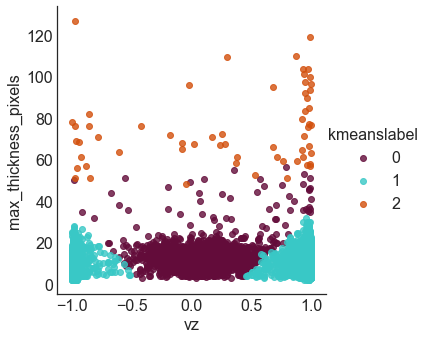

In [25]:
xin='vz'
yin='max_thickness_pixels'

facet = sns.lmplot(data = mytest, x=xin, y=yin, hue = 'kmeanslabel', fit_reg = False, legend=True , legend_out = True)
#plt.scatter(data = forplot, x=xin, y=yin, c = 'kmeanslabel', fit_reg = False, legend=True , legend_out = True, alpha=0.2)
#ax = sns.regplot(x=xin, y=yin, data=forplot, scatter_kws={'alpha':0.3}, fit_reg = False)

In [16]:
total_porevol = mytest['vol_pixels'].sum()
zero_porevol = mytest[mytest['kmeanslabel'] == 0]['vol_pixels'].sum()
ones_porevol = mytest[mytest['kmeanslabel'] == 1]['vol_pixels'].sum()
twos_porevol = mytest[mytest['kmeanslabel'] == 2]['vol_pixels'].sum()

In [17]:
zero_porevol*100/total_porevol, ones_porevol*100/total_porevol, twos_porevol*100/total_porevol

(14.644958903179576, 75.12433078021725, 10.230710316603169)

In [18]:
#from just max_thickness:
total_porevol_all = particleinfo['vol_pixels'].sum()
particleinfo[particleinfo['thickness_pixels'] > 20 ]['vol_pixels'].sum() * 100 / total_porevol_all
#mytest[(mytest['max_thickness_pixels'] > 12 ) & (mytest['thickness_pixels'] > 12)]

12.14029393401169

In [19]:
#particleinfo[(particleinfo['vz'].abs() > 0.7) & (particleinfo['thickness_pixels'] > 25) ]['vol_pixels'].sum() * 100 / total_porevol_all
particleinfo[particleinfo['thickness_pixels'] > 17]['vol_pixels'].sum() * 100 / total_porevol_all

15.45379894586643

In [26]:
#bigones=newall[newall['thickness_pixels'] > 17]
#longones=newall[(newall['thickness_pixels'] < 17) & (newall['vz'].abs() > 0.7)]
#querones=newall[(newall['thickness_pixels'] < 17) & (newall['vz'].abs() < 0.7)]
two_clusters=newall[newall['kmeanslabel'] == 2]
one_clusters=newall[newall['kmeanslabel'] == 1]
zero_clusters=newall[newall['kmeanslabel'] == 0]

In [27]:
#bigones.describe()
two_clusters.describe()

,local_id,vol_pixels,x_cent_pixels,y_cent_pixels,z_cent_pixels,sa_pixels,encl_vol_pixels,i1,i2,i3,vx,vy,vz,thickness_pixels,sd_thickness_pixels,max_thickness_pixels,major_radius_pixels,int_radius_pixels,minor_radius_pixels,kmeanslabel
count,60.000000,6.000000e+01,60.000000,60.000000,60.000000,60.000000,6.000000e+01,6.000000e+01,6.000000e+01,6.000000e+01,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,59.000000,60.000000,60.000000,60.0
mean,10499.266667,1.009645e+06,340.718317,342.700733,742.731483,73796.919883,1.012231e+06,4.314920e+09,3.946105e+09,1.525014e+09,-0.072110,0.002833,0.296550,61.532583,16.584283,75.248817,112.936424,62.859567,43.003317,2.0
std,4600.972266,7.970595e+05,247.228188,229.219114,371.572560,56209.514202,8.002712e+05,1.001418e+10,9.745021e+09,1.793244e+09,0.479272,0.345920,0.756896,16.641092,5.078921,18.399277,117.574962,13.917021,11.797552,0.0
min,481.000000,3.441990e+05,21.318000,28.906000,39.150000,30041.544000,3.444990e+05,3.406740e+08,3.056302e+08,2.085244e+08,-0.942000,-0.687000,-0.993000,35.063000,6.064000,48.042000,55.598000,45.004000,21.986000,2.0
25%,6620.000000,4.683975e+05,104.540000,161.958000,440.602500,37604.671250,4.677853e+05,7.258719e+08,5.565126e+08,3.767644e+08,-0.464250,-0.234500,-0.238750,49.468250,13.309500,61.269750,73.423000,49.875500,35.576500,2.0
50%,11339.500000,7.053180e+05,314.558500,282.633500,816.176500,55288.283000,7.150735e+05,1.451926e+09,1.189076e+09,7.197101e+08,-0.001301,0.011500,0.677500,59.834500,15.375000,70.979000,85.656000,61.936500,40.588500,2.0
75%,14610.750000,1.213478e+06,497.692750,485.689250,1059.991000,89862.956000,1.219940e+06,3.986860e+09,3.570646e+09,1.830562e+09,0.239500,0.208500,0.954000,68.534500,18.961250,85.970750,116.919500,70.896500,49.445250,2.0
max,17737.000000,4.448721e+06,914.309000,830.382000,1276.582000,324487.137000,4.476968e+06,7.216536e+10,7.081262e+10,8.257016e+09,0.797000,0.782000,1.000000,111.179000,29.104000,126.823000,949.232000,108.649000,73.694000,2.0


In [28]:
#longones.describe()
one_clusters.describe()

,local_id,vol_pixels,x_cent_pixels,y_cent_pixels,z_cent_pixels,sa_pixels,encl_vol_pixels,i1,i2,i3,vx,vy,vz,thickness_pixels,sd_thickness_pixels,max_thickness_pixels,major_radius_pixels,int_radius_pixels,minor_radius_pixels,kmeanslabel
count,12580.000000,12580.000000,12580.000000,12580.000000,12580.000000,12580.000000,12580.000000,1.258000e+04,1.258000e+04,1.258000e+04,12580.000000,12580.000000,12580.000000,12580.000000,12580.000000,12580.000000,6821.000000,11549.000000,12033.000000,12580.0
mean,8484.521860,35360.156598,475.411872,466.159547,651.508844,11122.742975,34534.384292,7.274841e+08,7.262763e+08,2.631430e+06,0.120237,0.052115,0.659027,8.356917,1.916269,10.787933,387.013915,26.031389,85.964612,1.0
std,5421.919252,44741.337891,293.378925,285.821522,414.298006,12459.868525,44096.321891,1.503704e+09,1.501872e+09,8.052984e+06,0.170298,0.113535,0.711799,4.306539,1.285483,5.754935,3242.811062,586.511012,3831.902157,0.0
min,1.000000,200.000000,1.117000,1.041000,4.862000,0.000000,0.000000,1.969410e+03,1.399201e+03,1.400400e+02,-0.890000,-0.770000,-1.000000,2.000000,0.000000,2.000000,2.285000,0.126000,0.059000,1.0
25%,3368.750000,1171.000000,211.641250,214.694500,248.214000,912.527750,877.395000,3.654552e+05,3.532457e+05,5.116216e+03,0.097000,-0.002000,0.954000,4.084750,0.717000,4.899000,35.760000,4.364000,2.563000,1.0
50%,8363.500000,14200.000000,475.991500,468.367500,655.252500,5769.706500,13614.666500,2.193432e+07,2.117547e+07,4.302751e+05,0.171000,0.069000,0.974000,8.166500,1.768500,10.770000,85.762000,9.570000,4.828000,1.0
75%,13242.250000,58091.500000,739.838250,716.226750,1045.537750,18991.239250,56689.677000,7.067049e+08,7.047010e+08,3.082948e+06,0.212000,0.116000,0.982000,11.891000,2.875000,15.621000,301.458000,15.192000,6.947000,1.0
max,18226.000000,275216.000000,937.717000,938.000000,1293.923000,81305.476000,276036.531000,2.049571e+10,2.046012e+10,4.025927e+08,0.841000,0.886000,1.000000,24.734000,8.133000,31.623000,168669.022000,58381.804000,408455.835000,1.0


In [29]:
#querones.describe()
zero_clusters.describe()

,local_id,vol_pixels,x_cent_pixels,y_cent_pixels,z_cent_pixels,sa_pixels,encl_vol_pixels,i1,i2,i3,vx,vy,vz,thickness_pixels,sd_thickness_pixels,max_thickness_pixels,major_radius_pixels,int_radius_pixels,minor_radius_pixels,kmeanslabel
count,5637.000000,5637.000000,5637.000000,5637.000000,5637.000000,5637.000000,5637.000000,5.637000e+03,5.637000e+03,5.637000e+03,5637.000000,5637.000000,5637.000000,5637.000000,5.637000e+03,5637.000000,5210.000000,5573.000000,5618.000000,5637.0
mean,10585.109455,15383.470640,485.773180,510.797059,672.163023,4660.288401,15018.001705,2.253844e+07,2.133906e+07,2.001808e+06,-0.424276,-0.300086,0.120570,10.751873,1.774038e+00,12.805774,82.623944,12.601289,22.900475,0.0
std,4623.123657,22567.005602,275.363594,274.255090,385.479692,5372.090781,22296.722121,2.461932e+08,2.404833e+08,1.323759e+07,0.668641,0.477110,0.202047,3.627937,9.247816e-01,4.119831,261.739525,12.990225,553.582975,0.0
min,10.000000,200.000000,3.771000,1.452000,1.630000,85.267000,41.260000,2.262167e+03,1.828455e+03,3.591550e+02,-0.998000,-0.999000,-0.981000,2.263000,8.259000e-08,2.828000,5.360000,1.081000,0.486000,0.0
25%,6451.000000,8263.000000,252.022000,283.593000,318.882000,2929.256000,7995.737000,2.041622e+06,1.792106e+06,2.614748e+05,-0.817000,-0.583000,0.059000,8.703000,1.270000e+00,10.770000,35.985000,9.274000,5.122250,0.0
50%,10654.000000,11968.000000,492.249000,522.733000,685.916000,3792.660000,11667.771000,4.400674e+06,4.062508e+06,4.907470e+05,-0.784000,-0.539000,0.187000,10.463000,1.624000e+00,12.649000,56.844000,10.909000,6.238000,0.0
75%,14575.000000,16402.000000,724.941000,751.281000,1009.407000,4928.788000,15983.759000,9.477363e+06,8.985343e+06,8.261703e+05,-0.601000,-0.357000,0.226000,12.457000,2.073000e+00,14.422000,86.057000,13.020000,7.467000,0.0
max,18277.000000,453117.000000,936.859000,937.231000,1297.642000,140441.337000,438643.625000,1.274693e+10,1.255655e+10,3.288463e+08,0.995000,0.998000,0.996000,47.600000,1.288800e+01,56.178000,13899.481000,485.430000,34203.089000,0.0


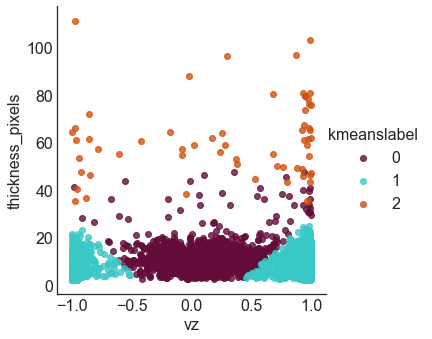

In [24]:
xin='vz'
yin='thickness_pixels'

facet = sns.lmplot(data = newall, x=xin, y=yin, hue = 'kmeanslabel', fit_reg = False, legend=True , legend_out = True)